In [ ]:
!pip install saliency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 935.7 kB/s eta 0:00:00


In [ ]:

# Boilerplate imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from matplotlib import pylab as P
import torch
import torchvision
from torchvision import models, transforms
from torchvision.models import Inception_V3_Weights
from torch.nn import ReLU
# From our repository.
import saliency.core as saliency
from PIL import Image
import os

from torch.autograd import Variable

%matplotlib inline


In [ ]:

##### Specify Device

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")


Training on GPU


In [ ]:

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path).convert('RGB')
    im = im.resize((224, 224))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImagesNOBATCH(images):
    # assumes input is 4-D, with range [0,255]
    images = np.array(images)
    images = images/255
    #print(images.shape)
    images = images.reshape(1,224,224,3)
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = images.to(device)
    images = transformer.forward(images)
    return images.requires_grad_(True)

def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    images = np.array(images)
    images = images/255
    #print(images.shape)
    #images = images.reshape(1,299,299,3)
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)


In [ ]:

model = torch.load('/content/drive/MyDrive/Saliency Map Research 2023/Models/pneumonia_dense.pt')
model = model.to(device)
eval_mode = model.eval()

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.features.denseblock4.denselayer16.conv2
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o.cpu(), 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0].cpu(), 1, 3).detach().numpy()

conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)


In [ ]:

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    images = images.to(device)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0].cpu(), 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs


Prediction class: 0


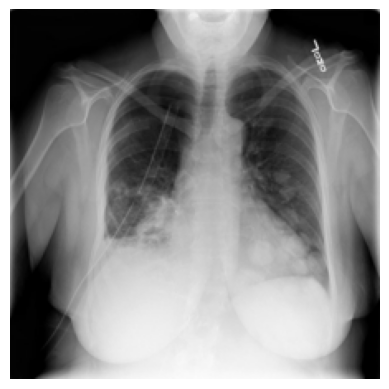

In [ ]:

# Load the image
path = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/stage_2_train_images_png/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.jpg.png'
im_orig = LoadImage(path)
im_tensor = PreprocessImagesNOBATCH(im_orig)
# Show the image
ShowImage(im_orig)

predictions = model(im_tensor)
predictions = predictions.detach().cpu().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))
im = im_orig
#.astype(np.float)


#Saliency Maps


In [ ]:

#Count files in directory

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/IG'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("Number of files:", file_count)


Number of files: 14324


In [ ]:
def make_labels(file_path):
  labels = pd.read_csv(file_path)
  labels = labels.drop(['x','y','width','height'], axis=1)
  labels = labels.drop_duplicates("patientId")
  return labels

labels = make_labels("/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/Pneumonia_Labels_Final_2.csv")
patientId = labels['patientId'].tolist()
lim_patientId = patientId

root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/stage_2_train_images_png'

In [ ]:
import os

# Original patient IDs
patientId = labels['patientId'].tolist()
lim_patientId = patientId

# Directory path
directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Dense (Tensor)/Grad'

# Get the list of patient IDs in the directory
file_names = os.listdir(directory_path)
directory_patient_ids = [file_name.split('_')[0] for file_name in file_names]

# Find the missing patient IDs
missing_patient_ids = [patient_id for patient_id in lim_patientId if patient_id not in directory_patient_ids]

print("Missing patient IDs:", missing_patient_ids)
print(len(missing_patient_ids))

Missing patient IDs: []
0


In [ ]:
#lim_patientId = lim_patientId[14310:]

In [ ]:

import time

start_time = time.time()

counter = 0

for label in patientId:

  counter += 1  # Increment the counter

  if counter % 10 == 0:  # Display the count for every 10th image
       print(f"Processing image {counter}/{len(lim_patientId)}")

  path = os.path.join(root, label + '.dcm.jpg.png')

  im = LoadImage(path)
  im_tensor = PreprocessImagesNOBATCH(im)
  predictions = model(im_tensor)
  predictions = predictions.detach().cpu().numpy()
  prediction_class = np.argmax(predictions[0])
  call_model_args = {class_idx_str: prediction_class}

  ######Grad######

  # Construct the saliency object. This alone doesn't do anthing.
  gradient_saliency = saliency.GradientSaliency()
  integrated_gradients = saliency.IntegratedGradients()
  xrai_object = saliency.XRAI()
  grad_cam = saliency.GradCam()

  # Compute the vanilla mask and the smoothed mask.
  vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
  smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

  ######IG######

  # Baseline is a black image.
  baseline = np.zeros(im.shape)

  # Compute the vanilla mask and the smoothed mask.
  vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
  # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
  smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

  #####XRAI######

  # Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
  xrai_params = saliency.XRAIParameters()
  xrai_params.algorithm = 'fast'

  # Compute XRAI attributions with fast algorithm
  xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

  ######GradCAM######

  # Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
  grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
  #smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)

  #Save the arrays
  #output_path = os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Dense (Heat Map)/ScoreCAM', label + '_saliency_map.jpg')
  torch.save(vanilla_mask_3d, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/Grad', label + '_saliency_map.pt'))
  torch.save(smoothgrad_mask_3d, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/Smooth Grad', label + '_saliency_map.pt'))
  torch.save(vanilla_integrated_gradients_mask_3d, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/IG', label + '_saliency_map.pt'))
  torch.save(smoothgrad_integrated_gradients_mask_3d, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/Smooth IG', label + '_saliency_map.pt'))
  torch.save(xrai_attributions_fast, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/XRAI', label + '_saliency_map.pt'))
  torch.save(grad_cam_mask_3d, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumonia Resnet (Tensor)/GradCAM', label + '_saliency_map.pt'))

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


/usr/local/lib/python3.10/dist-packages/saliency/core/xrai.py:126: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  masks = [dilation(mask, selem=selem) for mask in masks]


Processing image 10/551
Processing image 20/551
Processing image 30/551
Processing image 40/551
Processing image 50/551
Processing image 60/551
Processing image 70/551
Processing image 80/551
Processing image 90/551
Processing image 100/551
Processing image 110/551
Processing image 120/551
Processing image 130/551
Processing image 140/551
Processing image 150/551
Processing image 160/551
Processing image 170/551
Processing image 180/551
Processing image 190/551
Processing image 200/551
Processing image 210/551
Processing image 220/551
Processing image 230/551
Processing image 240/551
Processing image 250/551
Processing image 260/551
Processing image 270/551
Processing image 280/551
Processing image 290/551
Processing image 300/551
Processing image 310/551
Processing image 320/551
Processing image 330/551
Processing image 340/551
Processing image 350/551
Processing image 360/551
Processing image 370/551
Processing image 380/551
Processing image 390/551
Processing image 400/551
Processin

#Visualization

In [ ]:

# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))


In [ ]:

# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))


In [ ]:

# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast >= np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))


In [ ]:

# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smooth_grad_cam_mask_grayscale, title='Smoothgrad Grad-CAM', ax=P.subplot(ROWS, COLS, 2))
